In [21]:
%matplotlib inline
import dr_gen.analyze.plot_utils as pu
import random

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


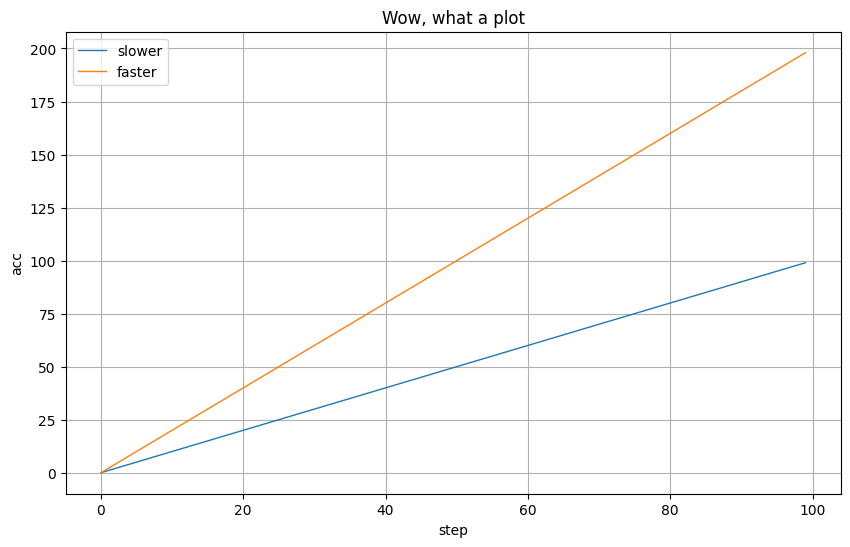

In [9]:
# Test: Make Line Plot
pu.make_line_plot(
    [list(range(100)), [i*2 for i in range(100)]],
    xs=list(range(100)),
    xlabel="step",
    ylabel="acc",
    title="Wow, what a plot",
    labels=["slower", "faster"],
)

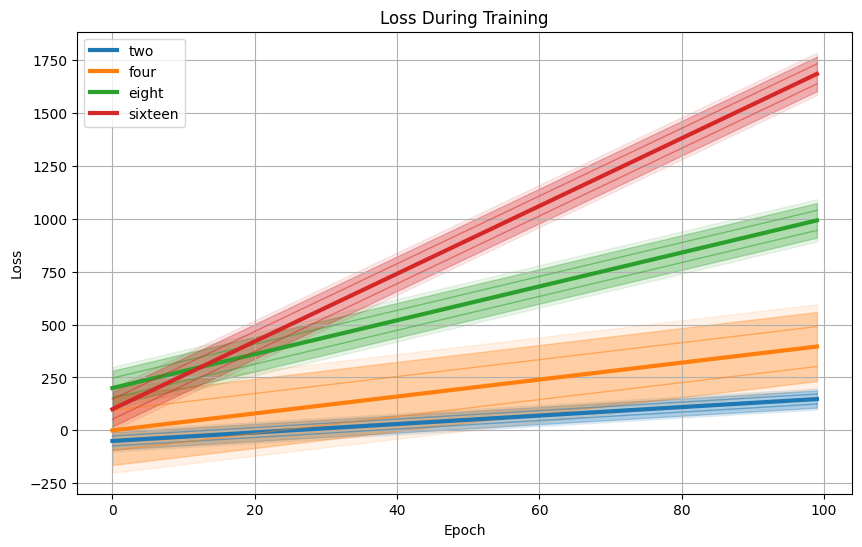

In [16]:
# Test: Make Summary Line Plot
pu.make_summary_line_plot(
    [
        [[i*2 - 100 for i in range(100)], [i*2 - 50 for i in range(100)], [i*2 for i in range(100)]], 
        [[i*4 - 200 for i in range(100)], [i*4 for i in range(100)], [i*4 + 200 for i in range(100)]], 
        [[i*8 + 100 for i in range(100)], [i*8 + 200 for i in range(100)], [i*8 + 300 for i in range(100)]], 
        [[i*16 for i in range(100)], [i*16 + 100 for i in range(100)], [i*16 + 200 for i in range(100)]], 
    ],
    labels=['two', 'four', 'eight', 'sixteen'],
)

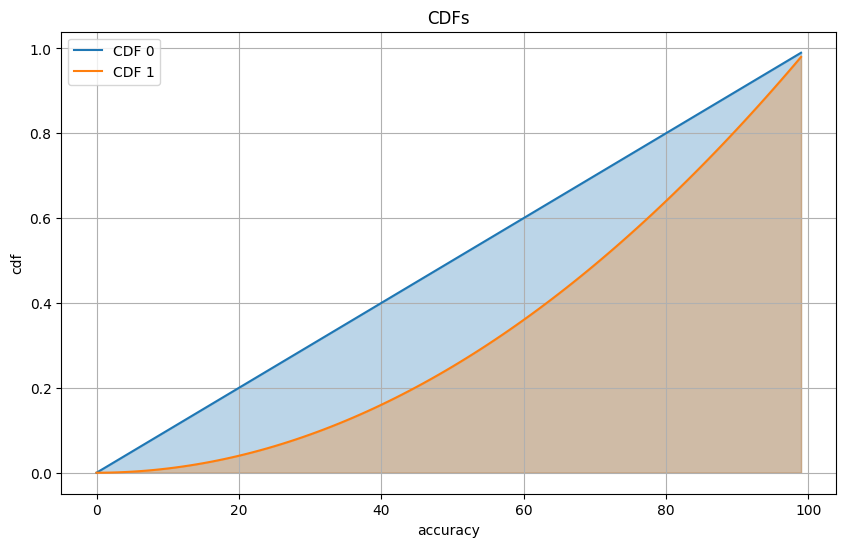

In [19]:
# Test: Make CDF Plot
pu.make_cdfs_plot(
    vals=list(range(100)),
    cdfs=[
        [i / 100.0 for i in range(100)],
        [i*i / (100.0 * 100.0) for i in range(100)],
    ],
)

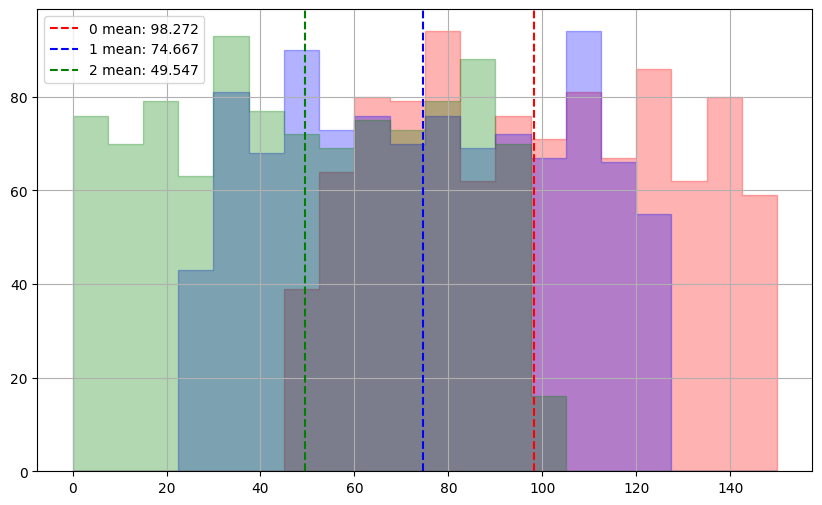

In [41]:
# Test: Make Histogram Plot
vals = [
    [rc + 50 for rc in random.choices(range(100), k=1000)],
    [rc + 25 for rc in random.choices(range(100), k=1000)],
    [rc for rc in random.choices(range(100), k=1000)],
]
means = [sum(v) / len(v) for v in vals]
pu.make_histogram_plot(
    vals,
    means=means,
    hist_range=(0,150),
    nbins=20,
    alpha=0.3,
    labels=[f"{i} mean: {means[i]}" for i in range(len(vals))],
)

In [10]:
%matplotlib inline

from hydra import initialize, compose
from omegaconf import OmegaConf 

import dr_gen.utils.run as ru
import dr_gen.utils.display as dsp
import dr_gen.analyze.result_parsing as rp
import dr_gen.analyze.plot_utils as pu
import dr_gen.analyze.histogram_plotting as hp
import dr_gen.analyze.ks_stats as ks
import dr_gen.analyze.result_plotting as rplt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup Config and Generator

In [2]:
with initialize(config_path="../configs/", version_base=None):
    cfg = compose(
        config_name="config.yaml",
        overrides=[
            "paths=mac",
        ]
    )

In [3]:
generator = ru.set_deterministic(cfg.seed)

In [4]:
print(OmegaConf.to_yaml(OmegaConf.to_container(cfg.paths, resolve=True)))

root: /Users/daniellerothermel/drotherm
proj_dir_name: dr_gen
data: /Users/daniellerothermel/drotherm/data
logs: /Users/daniellerothermel/drotherm/logs
my_data: /Users/daniellerothermel/drotherm/data/dr_gen
my_logs: /Users/daniellerothermel/drotherm/logs/dr_gen
run_dir: /Users/daniellerothermel/drotherm/logs/dr_gen/bs500/lr0.1/wd0.0001/s0/2025-03-04/12-11-1741111902
dataset_cache_root: /Users/daniellerothermel/drotherm/data/cifar10/
agg_results: /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/cluster_runs/lr_wd_init_v0



### Util Usage

#### Loading and Parsing Run Logs

In [5]:
# Example: Loading all Runs from Root Dir
run_logs = rp.get_all_logs(cfg.paths.agg_results)
print(f"\nFirst Run Keys: {run_logs[0].keys()}")

>> Getting logs from all runs in:
    /Users/daniellerothermel/drotherm/data/dr_gen/cifar10/cluster_runs/lr_wd_init_v0
>> Found 1,288 files
>> Loading files

First Run Keys: dict_keys(['log_path', 'log_data'])


In [6]:
# Example: Parsing a Single Run Log
rcfg, rmets, rmd = rp.parse_run_log(
    run_logs[0]['log_path'],
    run_logs[0]['log_data'],
)
print(f"\nSplits in first run: {list(rmets.keys())}")
print("\nFirst epoch train metrics:")
for k, v in rmets['train'][0].items():
    print(f"  - {k}: {v}")


Splits in first run: ['train', 'val', 'eval']

First epoch train metrics:
  - epoch: 0
  - loss: 1.841132915019989
  - acc1: 33.11750059127807
  - acc5: 84.29500131607055


In [7]:
# Example: Parsing all runs, dropping error runs
print(f">> Parsing {len(run_logs):,} Runs")
good_runs, bad_runs = rp.parse_run_logs(run_logs)
print(f"   - num good: {len(good_runs):,}")
print(f"   - num w/ errors: {len(bad_runs):,}")

>> Parsing 1,288 Runs
   - num good: 1,288
   - num w/ errors: 0


#### Determining the Sweeps in the Data

In [143]:
# Example: Getting Sweep Info & Simple Display
sweep_info = rp.extract_sweeps(good_runs)
swept_table = dsp.make_table(*rp.get_swept_table(sweep_info['swept_vals']))
print(f"Swept Values:\n{swept_table}")

Swept Values:
+--------------------+---------+-------+
|        Key         |  Values | Count |
+--------------------+---------+-------+
|   model.weights    |   None  |  680  |
|                    | DEFAULT |  608  |
+--------------------+---------+-------+
| optim.weight_decay | 0.00025 |  200  |
|                    | 0.00016 |  200  |
|                    | 6.3e-05 |  200  |
|                    |  0.0001 |  423  |
|                    |  4e-05  |  200  |
|                    |  1e-05  |   65  |
+--------------------+---------+-------+
|      optim.lr      |   0.04  |  200  |
|                    |   0.06  |  200  |
|                    |   0.25  |  200  |
|                    |   0.1   |  383  |
|                    |   0.16  |  200  |
|                    |   0.2   |   40  |
|                    |   0.01  |   65  |
+--------------------+---------+-------+
|  optim.step_size   |    90   |  1287 |
|                    |    60   |   1   |
+--------------------+---------+-------+
| 

In [144]:
# Example: Show the Sweep Combo Run Info
combo_table = dsp.make_table(*rp.get_combo_table_contents(
    sweep_info['combo_key_order'],
    sweep_info['combo_inds'],
))

print(">> First 5 lines of combos")
print(combo_table.get_string(start=0, end=5))

print("\n>> Just Default HPMs")
def filter_function(vals):
    return (
        #vals[0] == "None" and   # Init
        vals[1] == "0.1" and     # LR
        vals[2] == "0.0001" and  # WD
        vals[4] == "270"         # Epochs
    )
print(combo_table.get_string(row_filter=filter_function))

>> First 5 lines of combos
+------+------+---------+-----------------+--------+-------+
| Init |  LR  |    WD   | optim.step_size | epochs | Count |
+------+------+---------+-----------------+--------+-------+
| None | 0.25 | 6.3e-05 |        90       |  270   |   20  |
| None | 0.25 |  4e-05  |        90       |  270   |   20  |
| None | 0.25 | 0.00025 |        90       |  270   |   20  |
| None | 0.25 | 0.00016 |        90       |  270   |   20  |
| None | 0.25 |  0.0001 |        90       |  270   |   20  |
+------+------+---------+-----------------+--------+-------+

>> Just Default HPMs
+---------+-----+--------+-----------------+--------+-------+
|   Init  |  LR |   WD   | optim.step_size | epochs | Count |
+---------+-----+--------+-----------------+--------+-------+
|   None  | 0.1 | 0.0001 |        90       |  270   |   99  |
| DEFAULT | 0.1 | 0.0001 |        90       |  270   |  103  |
+---------+-----+--------+-----------------+--------+-------+


In [142]:
# Example: Get inds for specific configuration
# Here selected_inds is {(combo_keys): [inds, ...]}
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
    },
)
dsp.make_table(
    [*sweep_info['combo_key_order'], "Count"],
    [[*k, len(selected_inds[k])] for k in selected_inds.keys()],
)

model.weights,optim.weight_decay,optim.lr,optim.step_size,epochs,Count
None,0.00025,0.1,90,270,20
None,0.0001,0.1,90,270,99
None,4e-05,0.1,90,270,20
None,6.3e-05,0.1,90,270,20
None,0.00016,0.1,90,270,20
None,1e-05,0.1,90,270,20


#### Format and Extract Metrics

In [150]:
all_runs_metrics = rp.remap_run_list_metrics(good_runs)
print(f">> Splits: {list(all_runs_metrics.keys())}")
print(f">> Metrics: {list(all_runs_metrics['train'].keys())}")

>> Splits: ['train', 'val', 'eval']
>> Metrics: ['epoch', 'loss', 'acc1', 'acc5']


In [171]:
# Example: Get specific metric for a single run
rp.get_run_metrics(all_runs_metrics, "train", "loss", 0)[:5]

[1.841132915019989,
 1.4623212695121766,
 1.3068945199251174,
 1.198164589703083,
 1.113237025588751]

In [168]:
# Example: Get specific metric for list of inds
two_mets = rp.get_runs_metrics(all_runs_metrics, "train", "loss", [0,1])
print(">> Loss for two runs")
dsp.make_table(['Run 0', 'Run 1'], [[two_mets[0][i], two_mets[1][i]] for i in range(4)])

>> Loss for two runs


Run 0,Run 1
1.841132915019989,1.8647861450910568
1.4623212695121766,1.4779982462525367
1.3068945199251174,1.3190233439207077
1.198164589703083,1.2109674647450448


In [189]:
# Example: Get inds for specific configuration
# Here selected_inds is {(combo_keys): [inds, ...]}
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    },
)
print(dsp.make_table(
    [*sweep_info['combo_key_order'], "Count"],
    [[*k, len(selected_inds[k])] for k in selected_inds.keys()],
))
selected_metrics = rp.get_selected_run_metrics(
    all_runs_metrics,
    "train",
    "loss",
    selected_inds,
)
for k, v in selected_metrics.items():
    print(f">> Selected values: {k}")
    print(f"  - Num Runs: {len(v)}")
    print(f"  - Epochs Per Run: {len(v[0])}")
    print(f"  - First few metric vals: {v[0][:6]}")
    print()

+---------------+--------------------+----------+-----------------+--------+-------+
| model.weights | optim.weight_decay | optim.lr | optim.step_size | epochs | Count |
+---------------+--------------------+----------+-----------------+--------+-------+
|      None     |       0.0001       |   0.1    |        90       |  270   |   99  |
|    DEFAULT    |       0.0001       |   0.1    |        90       |  270   |  103  |
+---------------+--------------------+----------+-----------------+--------+-------+
>> Selected values: ('None', '0.0001', '0.1', '90', '270')
  - Num Runs: 99
  - Epochs Per Run: 270
  - First few metric vals: [2.668017143011093, 1.7718266412615775, 1.5857333675026895, 1.4439559295773505, 1.337556365132332, 1.2246724620461464]

>> Selected values: ('DEFAULT', '0.0001', '0.1', '90', '270')
  - Num Runs: 103
  - Epochs Per Run: 270
  - First few metric vals: [2.1537656500935554, 1.768149584531784, 1.5912721008062363, 1.3348946005105973, 1.1988739788532257, 1.0811110228

#### Basic Plotting Utils

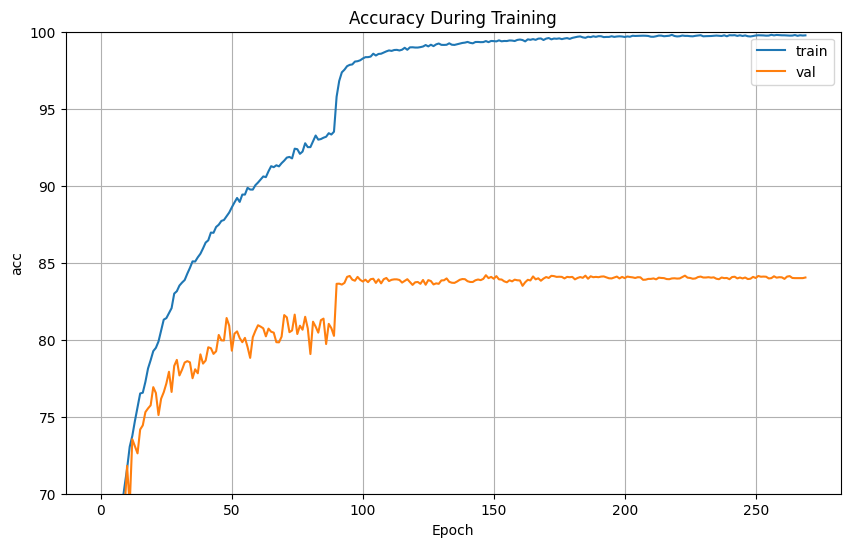

In [204]:
# Example: Plot multiple splits for same run
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc", title="Accuracy During Training",
        ylim=(70, 100), labels=['train', 'val']
    ),
    [
        rp.get_run_metrics(all_runs_metrics, "train", "acc1", 0),
        rp.get_run_metrics(all_runs_metrics, "val", "acc1", 0),
    ],
)

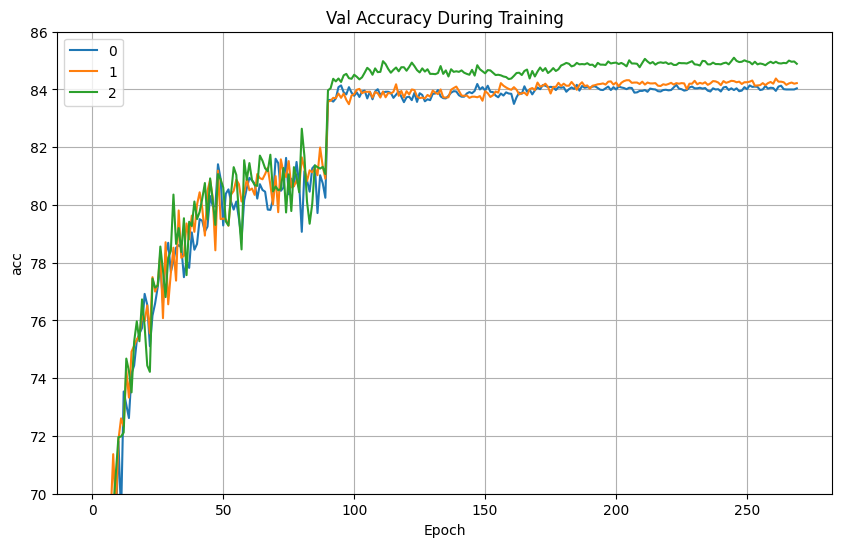

In [208]:
# Example: Plot one split for multiple inds (manually selected)
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc", title="Val Accuracy During Training",
        ylim=(70, 86), labels=[0,1,2],
    ),
    rp.get_runs_metrics(all_runs_metrics, "val", "acc1", [0,1,2]),
)

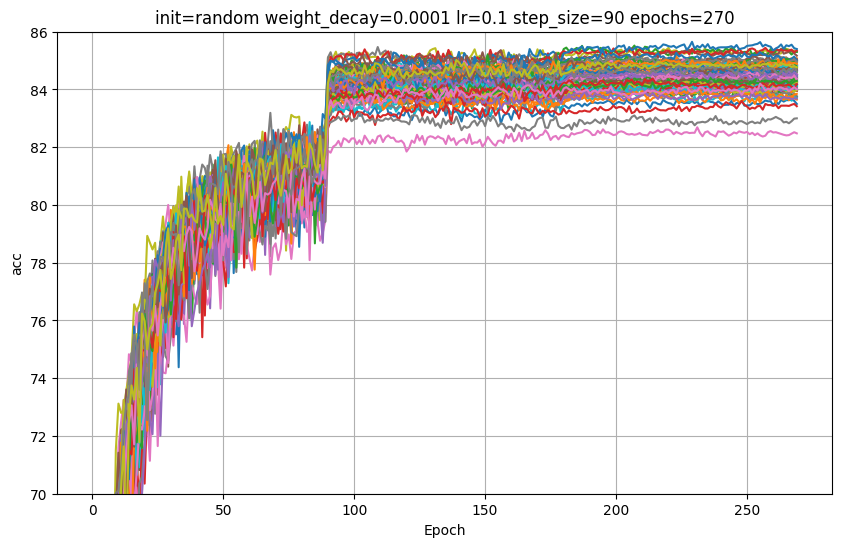

In [305]:
# Example: Plot one split for multiple inds (selected via combo)
selected_inds = rp.get_inds_by_kvs(
    sweep_info['combo_key_order'], sweep_info['combo_inds'],
    {
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    },
)
selected_metrics = list(rp.get_selected_run_metrics(
    all_runs_metrics,
    "val",
    "acc1",
    selected_inds,
).items())
met_keys = [sm[0] for sm in selected_metrics]
met_values = [sm[1] for sm in selected_metrics]
pu.plot_lines(
    pu.get_plt_cfg(
        ylabel="acc",
        title=rplt.kvs_to_str(
            list(zip(sweep_info['combo_key_order'], met_keys[0]))
        ),
        ylim=(70, 86),
        legend=False,
        #labels=[str(k) for k in selected_metrics],
    ),
    met_values[0],
)

#### Simple Histogram and Ind Data

In [330]:
# Example of getting aggregate stats and vals for a single ind
all_kvs, all_split_vals, _ = rp.get_selected_combo(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=5,
)
rd_stats_ind100 = pu.get_runs_data_stats_ind(
    all_split_vals['val'][0],
    ind=100,
)
rd_stats_ind100

{'epochs': np.int64(100),
 'mean': np.float64(84.09199829101563),
 'std': np.float64(0.35684236456496604),
 'sem': np.float64(0.15958475688380525),
 'std_lower': np.float64(83.73515592645066),
 'std_upper': np.float64(84.4488406555806),
 'sem_lower': np.float64(83.93241353413183),
 'sem_upper': np.float64(84.25158304789943),
 'min': np.float64(83.68999481201172),
 'max': np.float64(84.70999908447266),
 'n': 5,
 'vals': [84.23999786376953,
  83.86000061035156,
  84.70999908447266,
  83.95999908447266,
  83.68999481201172]}

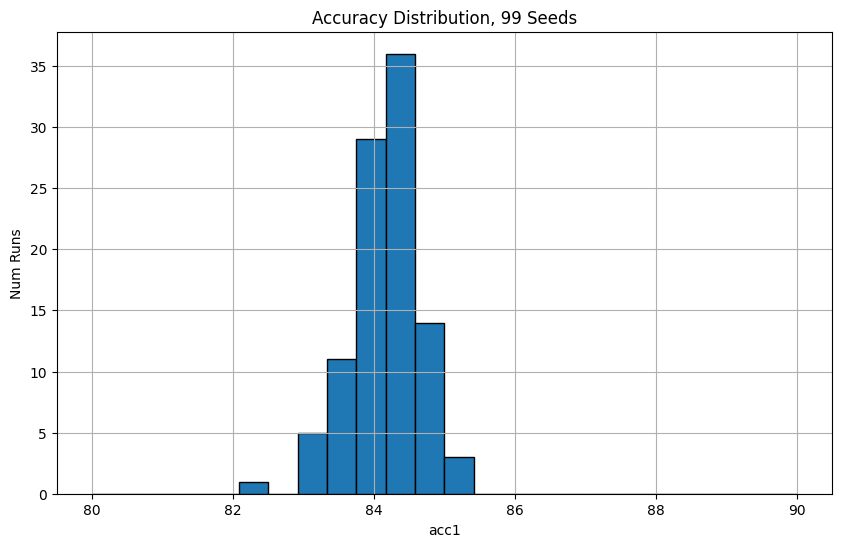

In [353]:
all_kvs, all_split_vals, _ = rp.get_selected_combo(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
)
rd_stats_ind100 = pu.get_runs_data_stats_ind(
    all_split_vals['val'][0],
    ind=100,
)
hp.plot_histogram(
    pu.get_plt_cfg(
        nbins=rd_stats_ind100['n']//4,
        hist_range=(80, 90),
        title=f"Accuracy Distribution, {rd_stats_ind100['n']} Seeds",
        ylabel="Num Runs",
    ),
    rd_stats_ind100['vals'],    
)

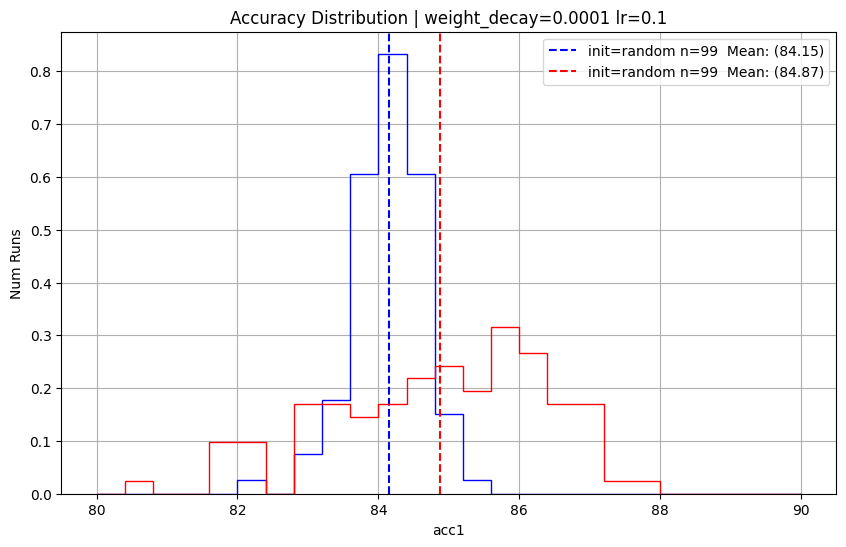

In [420]:
all_kvs, all_split_vals, _ = rp.get_selected_combo(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
)
stats1_ind100 = pu.get_runs_data_stats_ind(
    all_split_vals['val'][0],
    ind=100
)
stats2_ind100 = pu.get_runs_data_stats_ind( 
    all_split_vals['val'][1],
    ind=100,
)
labels_kvstrs = [
    rplt.kvs_to_str(
        [(k, v) for k, v in kvs if k == "model.weights"]
    ) for kvs in all_kvs
]
title_kvstr = rplt.kvs_to_str(
    [(k, v) for k, v in all_kvs[0] if k != "model.weights"]
)
ns = [stats1_ind100['n'], stats2_ind100['n']]
hp.plot_histogram_compare(
    pu.get_plt_cfg(
        nbins=max(ns)//4,
        hist_range=(80, 90),
        title=f"Accuracy Distribution | {title_kvstr}",
        ylabel="Num Runs",
        labels=[
            rplt.kvs_to_str(
                [(k, v) for k, v in kvs if k == "model.weights"]
            ) + f" n={ns[i]} " for i, kvs in enumerate(all_kvs)
        ],
    ),
    [
        stats1_ind100,
        stats2_ind100,
    ],
)

ks_stat: 0.5118, p_value: 1.3710e-12 | max_val: 84.73, cdf1_val: 0.9293, cdf2_val: 0.4175


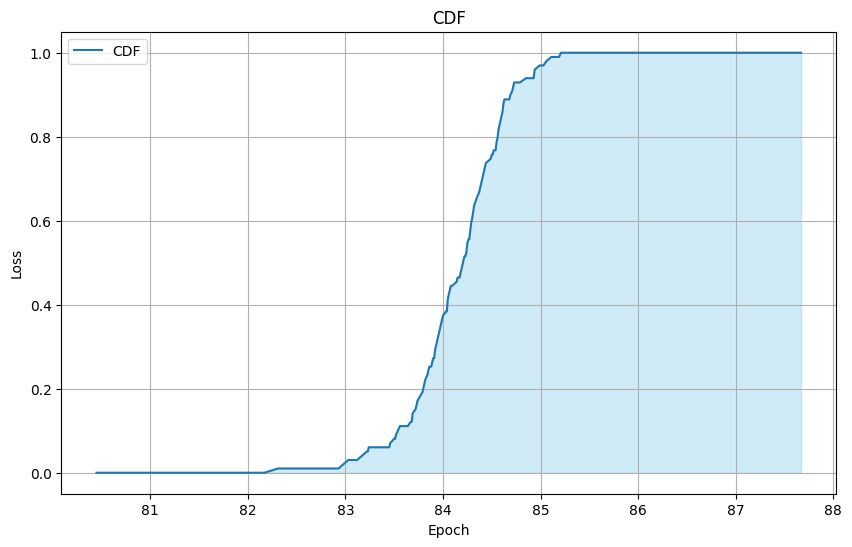

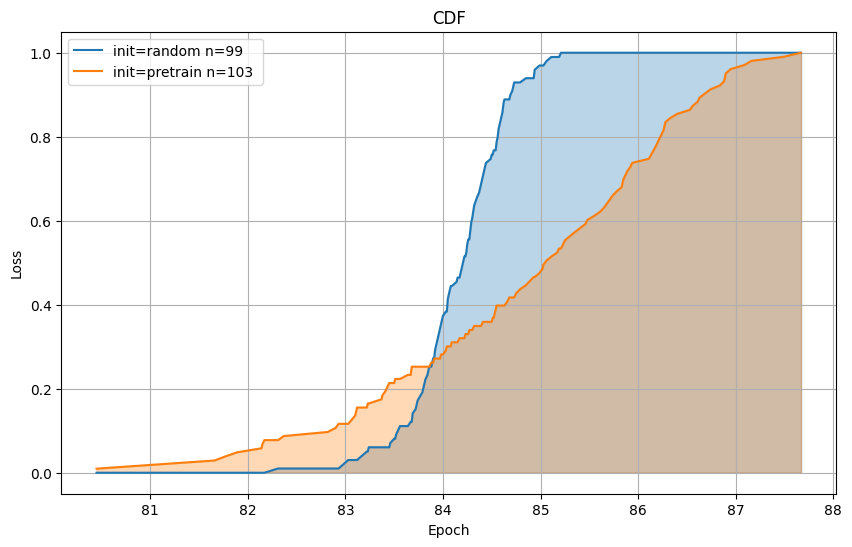

In [451]:
all_kvs, all_split_vals, _ = rp.get_selected_combo(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
)
stats1_ind100 = pu.get_runs_data_stats_ind(
    all_split_vals['val'][0],
    ind=100
)
stats2_ind100 = pu.get_runs_data_stats_ind( 
    all_split_vals['val'][1],
    ind=100,
)
results = ks.calculate_ks_for_run_sets(
    stats1_ind100['vals'],
    stats2_ind100['vals'],
)
pu.plot_cdf(
    pu.get_plt_cfg(),
    results['all_vals'],
    results['cdf1'],
)
pu.plot_cdfs(
    pu.get_plt_cfg(
        labels=[
            rplt.kvs_to_str(
                [(k, v) for k, v in kvs if k == "model.weights"]
            ) + f" n={ns[i]} " for i, kvs in enumerate(all_kvs)
        ],
    ),
    results['all_vals'],
    [
        results['cdf1'],
        results['cdf2'],
    ]
)

#### Using Result Plotting Utils

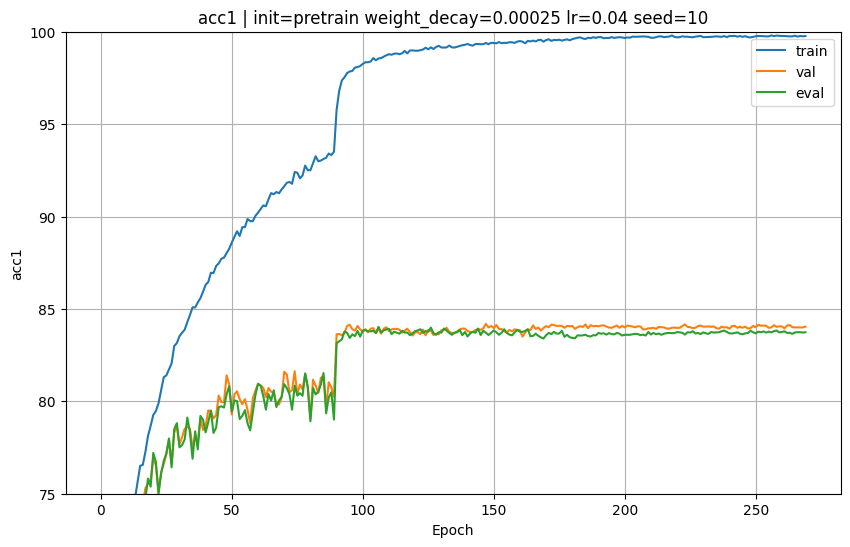

In [306]:
rplt.plot_run_splits(
    good_runs,
    all_runs_metrics,
    sweep_info,
    run_ind=0,
    ignore_keys=['optim.step_size', 'epochs'],
    ylim=(75, 100),
)

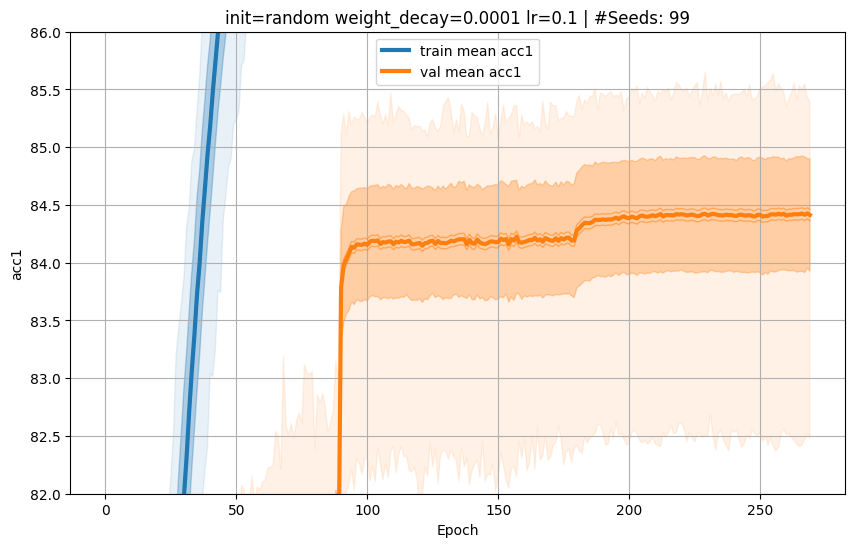

In [322]:
rplt.plot_split_summaries(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=None,
    ylim=(82, 86),
)
    

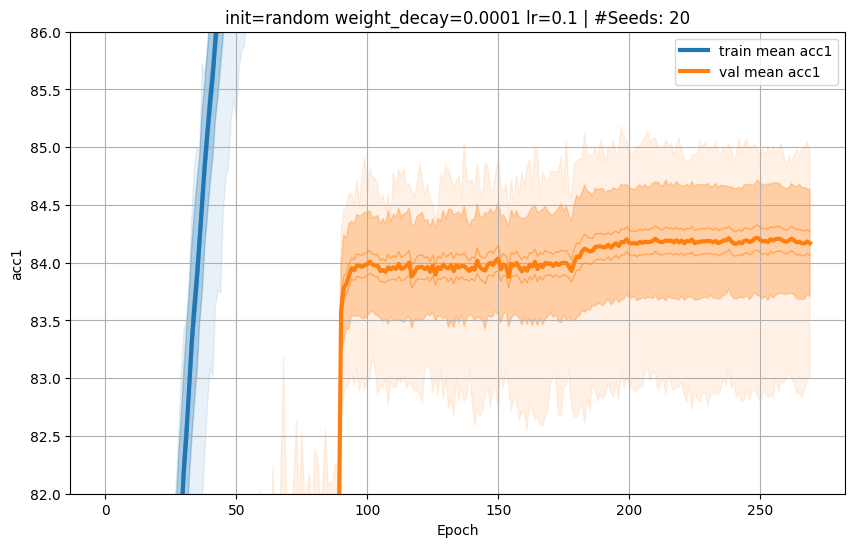

In [323]:
rplt.plot_split_summaries(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    splits=['train', 'val'],
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=20,
    ylim=(82, 86),
)
    

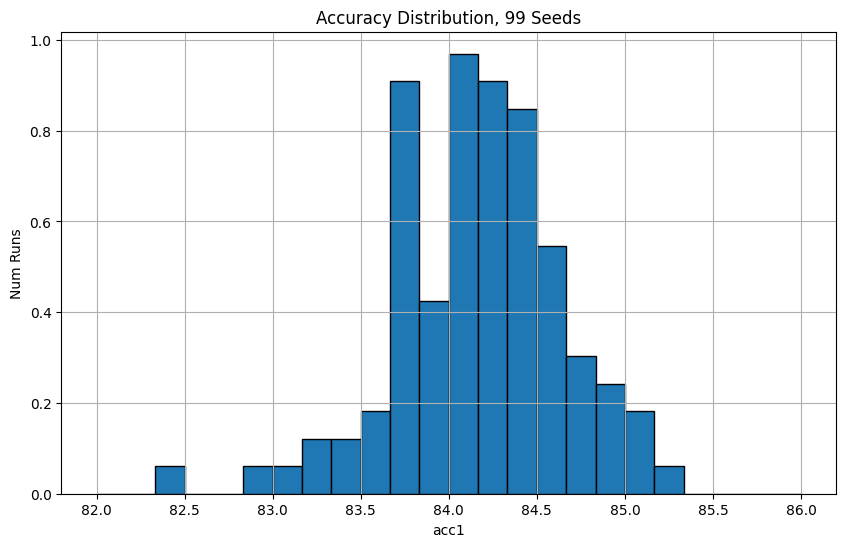

In [407]:
rplt.plot_combo_histogram(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split='val',
    epoch=110,
    metric='acc1',
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=None,
    #nbins=10,
    hist_range=(82,86),
    density=True,
)

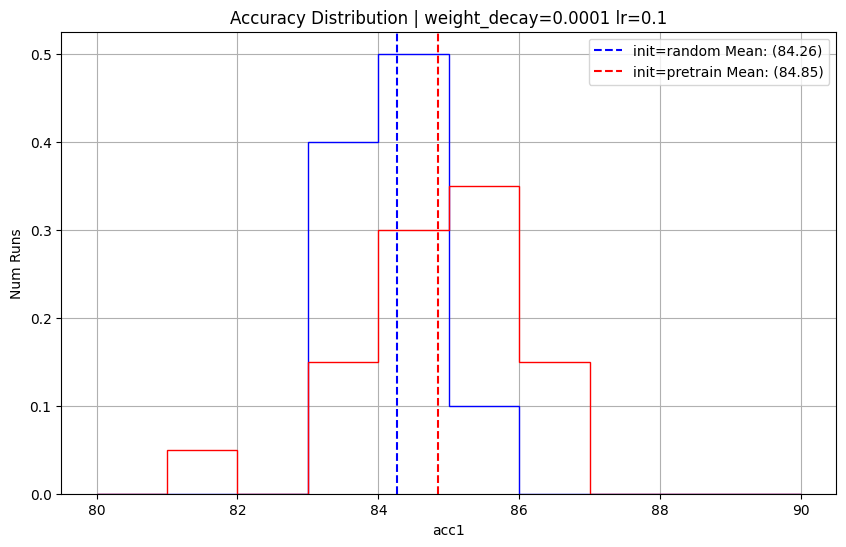

In [435]:
rplt.plot_combo_histogram_compare(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=20,
    nbins=10,
    vary_key="model.weights",
)

ks_stat: 0.5118, p_value: 1.3710e-12 | max_val: 84.73, cdf1_val: 0.9293, cdf2_val: 0.4175


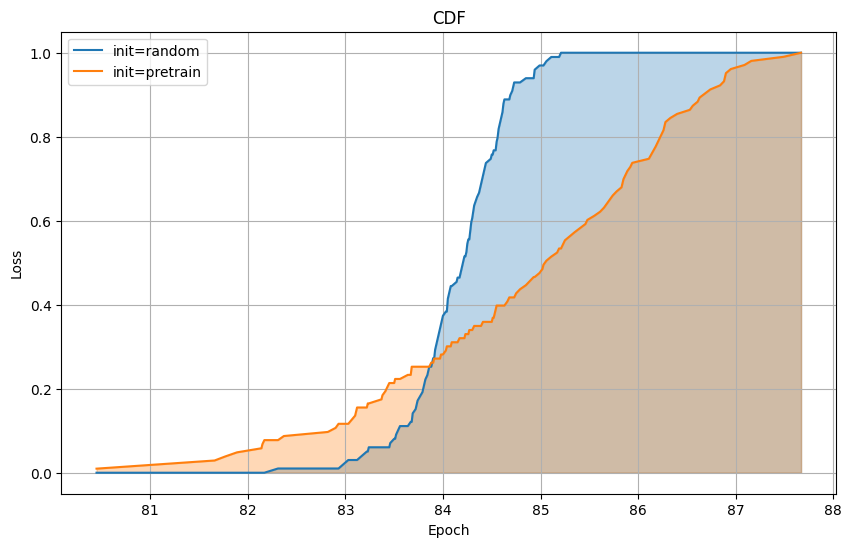

In [456]:
rplt.ks_stats_plot_cdfs(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=None,
    vary_key="model.weights",
)

ks_stat: 1.0000, p_value: 8.1460e-23 | max_val: 81.00, cdf1_val: 0.0000, cdf2_val: 1.0000


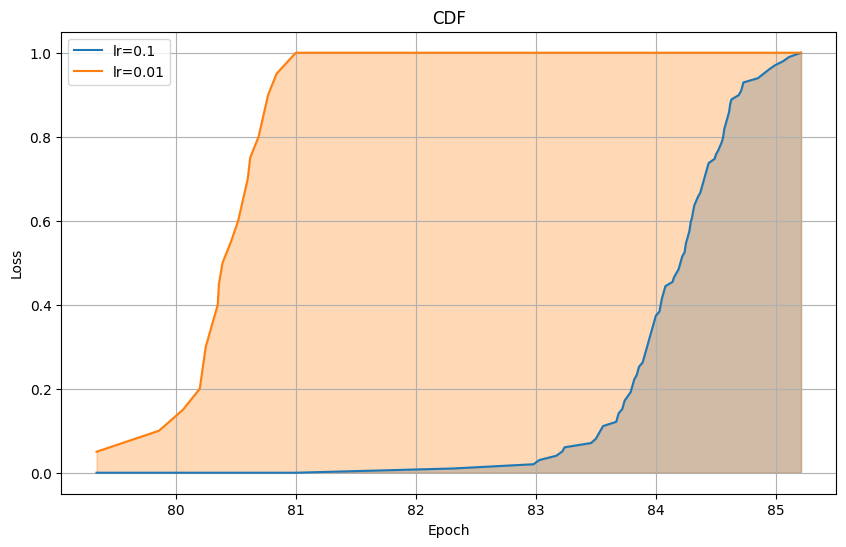

In [463]:
rplt.ks_stats_plot_cdfs(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        #'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=None,
    vary_key="optim.lr",
    vary_vals=[str(v) for v in [0.1, 0.01]],
)

ks_stat: 0.5118, p_value: 1.3710e-12 | max_val: 84.73, cdf1_val: 0.9293, cdf2_val: 0.4175


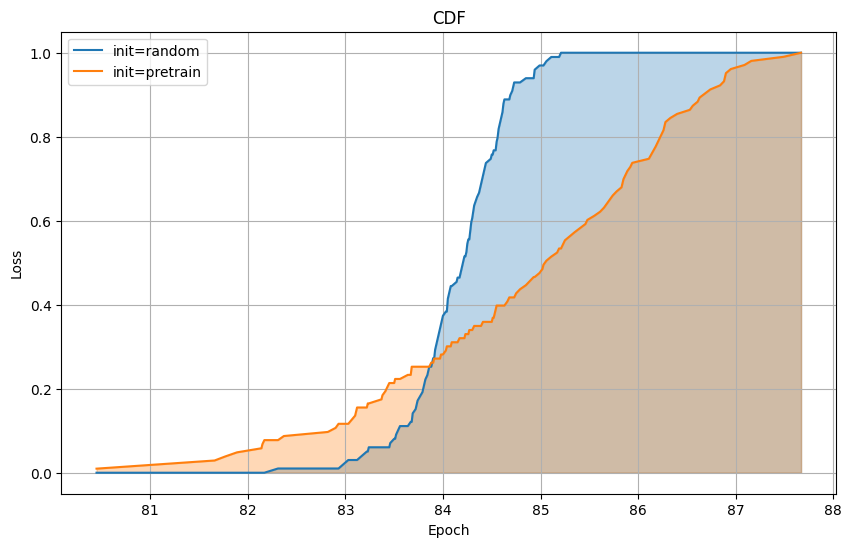

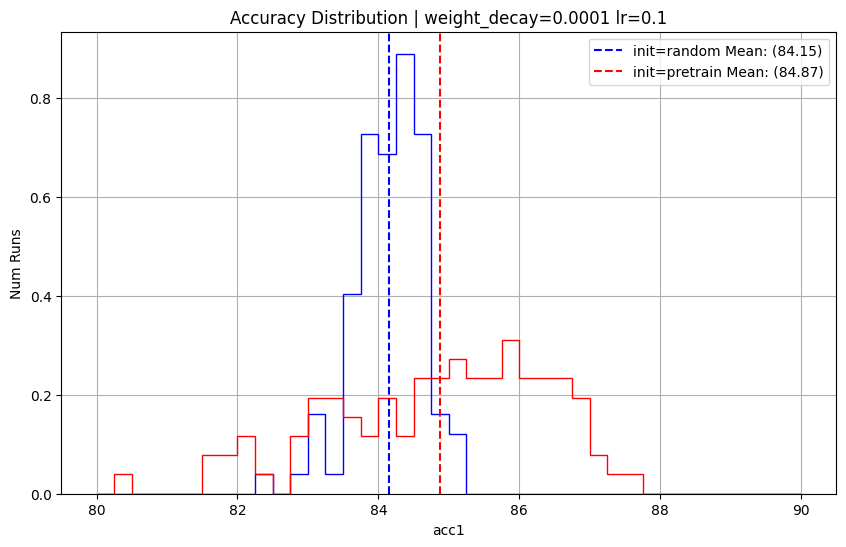

In [468]:
rplt.ks_stat_plot_cdfs_histograms(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        #'model.weights': 'None',
        'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=None,
    vary_key="model.weights",
    nbins=40,
)

ks_stat: 1.0000, p_value: 1.4509e-11 | max_val: 81.00, cdf1_val: 0.0000, cdf2_val: 1.0000


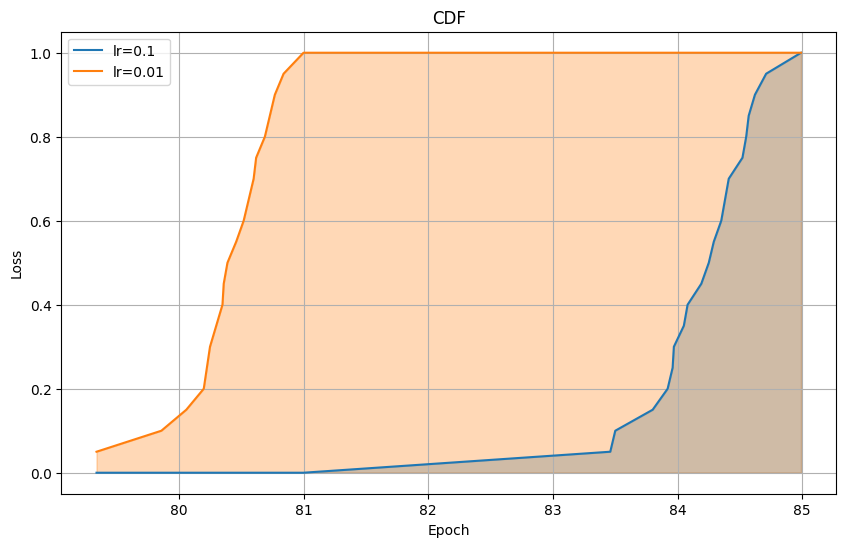

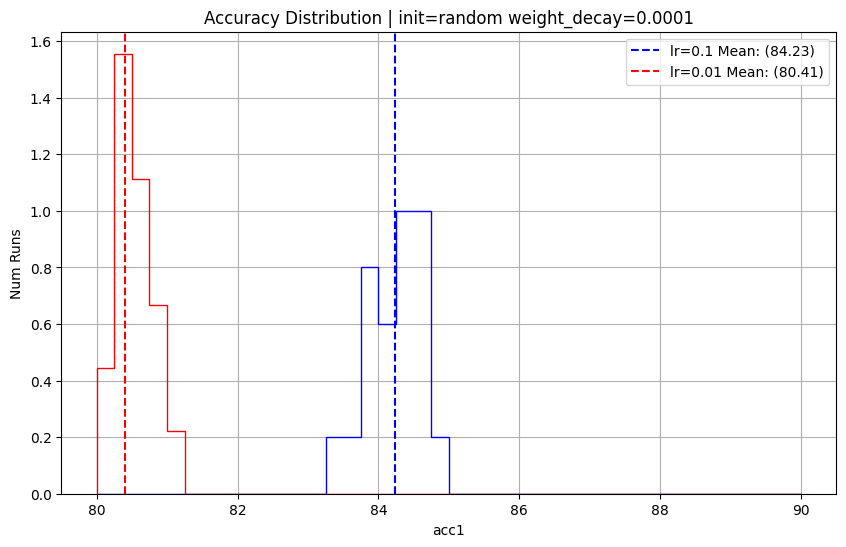

In [481]:
rplt.ks_stat_plot_cdfs_histograms(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        #'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=20,
    vary_key="optim.lr",
    vary_vals=[str(lr) for lr in [0.1, 0.01]],
    nbins=40,
)

ks_stat: 0.8000, p_value: 1.3260e-06 | max_val: 83.54, cdf1_val: 0.0500, cdf2_val: 0.8500


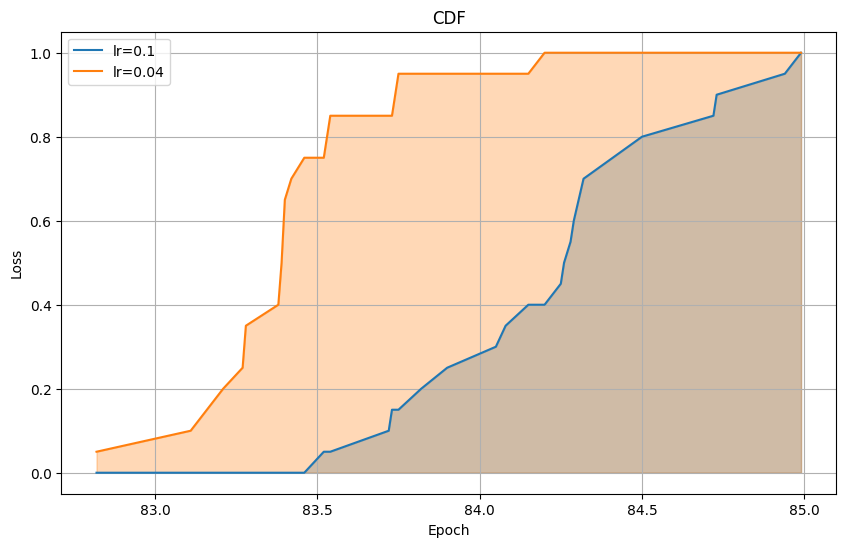

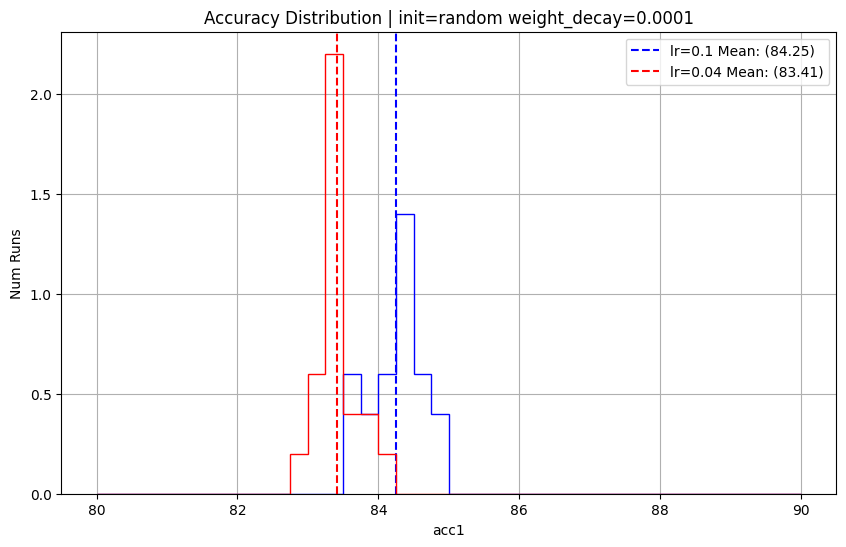

In [480]:
rplt.ks_stat_plot_cdfs_histograms(
    good_runs,
    all_runs_metrics,
    sweep_info,
    kv_select={
        'epochs': '270',
        'model.weights': 'None',
        #'optim.lr': '0.1',
        'optim.weight_decay': '0.0001',
    }, 
    split="val",
    epoch=100,
    metric="acc1",
    ignore_keys=["optim.step_size", "epochs"],
    num_seeds=20,
    vary_key="optim.lr",
    vary_vals=[str(lr) for lr in [0.1, 0.04]],
    nbins=40,
)